# Qiskit Tutorial Part 4: Quantum Algorithms

*This is part of the Qiskit Tutorial series by Yen Lee Loh.  Edited 2023-6-4.*

## 1. Import modules

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import qiskit
import qute


$\newcommand{\mean}[1]{\langle #1 \rangle}$
$\newcommand{\bra}[1]{\langle #1 \rvert}$
$\newcommand{\ket}[1]{\lvert #1 \rangle}$
$\newcommand{\adag}{a^\dagger}$
$\newcommand{\mat}[1]{\underline{\underline{\mathbf{#1}}}}$
$\newcommand{\beq}{\qquad\begin{align}}$
$\newcommand{\eeq}{\end{align}}$
$\newcommand{\half}{\frac{1}{2}}$


## 2. Deutsch algorithm

Run the code below, which demonstrates Deutsch's algorithm:

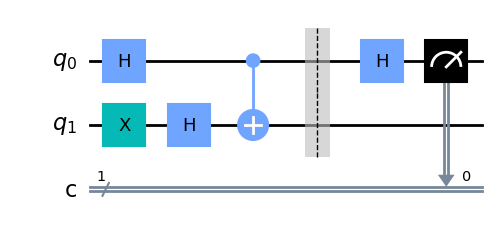

Oracle                 : f(0)=0, f(1)=1
Oracle type            : 1              (0=constant, 1=balanced)
Measured classical bit : 1


In [2]:
rng = np.random.default_rng()
oracle = rng.integers(4)      # oracle=2 means f(0)=1 and f(1)=0; oracle=3 means f(0)=1 and f(1)=1
#======== Apply H0,X1,H1 
cir = qiskit.QuantumCircuit(2,1)
cir.h(0); cir.x(1); cir.h(1)
#======== Consult oracle
if oracle==0: pass            # oracle output is always 0, so nothing happens
if oracle==1: cir.cx(0,1)     # oracle returns f(x)=x, so this is a regular CNOT gate
if oracle==2: cir.x(0); cir.cx(0,1); cir.x(0); # oracle returns f(x)=1-x
if oracle==3: cir.x(1)        # oracle output is always 1, so output qubit gets flipped
#======== Apply H0,M0
cir.barrier()
cir.h(0)
cir.measure([0],[0])
#======== Draw circuit
display (cir.draw('mpl')) 
#======== Test circuit
cts = qute.getCounts (qute.run (cir))
print(f'Oracle                 : f(0)={oracle>>1}, f(1)={oracle&1}')
print(f'Oracle type            : {1 if oracle==1 or oracle==2 else 0}              (0=constant, 1=balanced)')
print(f'Measured classical bit : {list(cts)[0]}')

The above code randomly chooses an oracle function from the following 4 possibilities:

    f(0)=0, f(1)=0      (constant)
    f(0)=0, f(1)=1      (balanced)
    f(0)=1, f(1)=0      (balanced)
    f(0)=1, f(1)=1      (constant).

A classical algorithm must consult the oracle 2 times to determine whether the oracle is constant or balanced.  In contrast, the Deutsch algorithm on a quantum computer only needs to consult the oracle once.  The demonstration above shows that the measured classical bit matches the oracle type 100% of the time.

## 3. Deutsch-Josza algorithm (TBD)

## 4. Grover algorithm

$\newcommand{\fff}{\mathbf{f}}$
$\newcommand{\ggg}{\mathbf{g}}$
$\newcommand{\xxx}{\mathbf{x}}$
Let $f(\xxx):{\mathbb{Z}_2}^n \rightarrow \mathbb{Z}_2$ be a classical oracle, which is a function of $n$ input bits that returns either 0 or 1.  Assume that 

$\beq
f(\xxx) = 
    \begin{cases}
    1  ~~~ & \xxx=\fff \\
    0      & \xxx\neq\fff .
    \end{cases}
\eeq$

where $\fff$ is a particular bitstring called the "solution", "marked state", or "good state".
Let $\hat{F}$ be a quantum oracle that flips the output qubit depending on the value of the input register, such that

$\beq
\hat{F} \ket{\xxx} \otimes \ket{y}  &= \ket{\xxx} \otimes \ket{y\oplus f(\xxx)}.
\eeq$

Grover's algorithm is as follows:
1. Put the input register into a uniform superposition state, $\sum_{\xxx=0}^{2^n-1} \ket{\xxx}$.
2. Put the output bit in the $\ket{-}$ state.
3. Apply the oracle gate $\hat{F}$.
4. Apply the Grover gate $\hat{G} = \hat{H}_0 \dots \hat{H}_{n-1} \hat{X}_0 \dots \hat{X}_{n-1} \hat{X}_{012\dots n}  \hat{X}_0 \dots \hat{X}_{n-1} \hat{H}_0 \dots \hat{H}_{n-1} $.
5. Repeat the previous two steps approximately $0.75\sqrt{2^n}$ times.
6. Measure the input register.

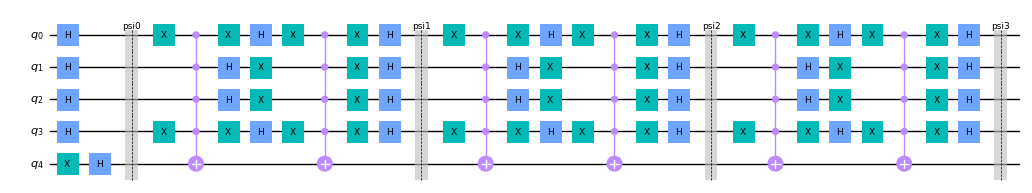

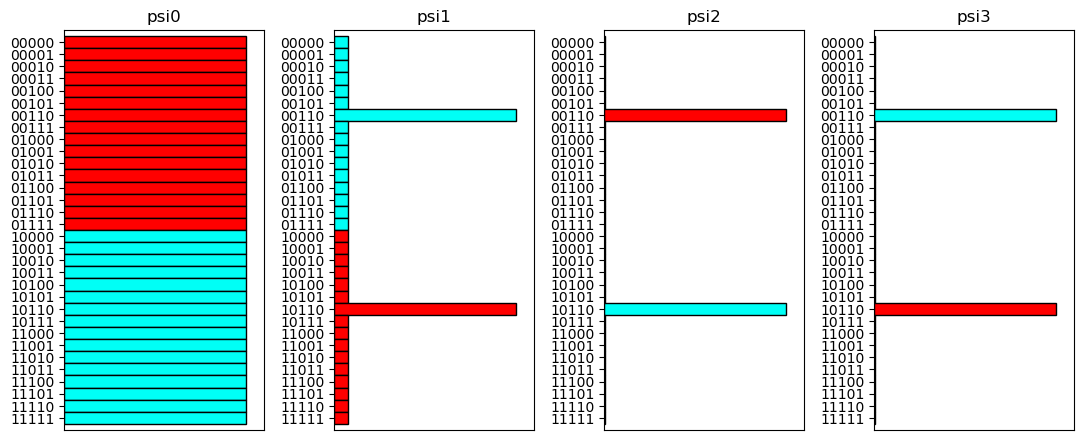

In [3]:
n = 4
#======== Prepare the oracle gate FFF
cir = qiskit.QuantumCircuit(n+1)
cir.x ([0,3])
cir.mcx (list(range(n)), n)
cir.x ([0,3])
FFF = cir.copy()
#======== Prepare the Grover gate GGG
cir = qiskit.QuantumCircuit(n+1)
cir.h (range(n))
cir.x (range(n))
cir.mcx (list(range(n)), n)
cir.x (range(n))
cir.h (range(n))
GGG = cir.copy()
#======== Build the circuit for Grover's algorithm with 3 iterations
cir = qiskit.QuantumCircuit(n+1)
cir.h(range(n))                     # put input register in uniform superposition using Walsh transform.
cir.x(n); cir.h(n)                  # put output bit into |-> state
cir.save_statevector ('psi0')
cir.compose (FFF, inplace=True)
cir.compose (GGG, inplace=True)
cir.save_statevector ('psi1')
cir.compose (FFF, inplace=True)
cir.compose (GGG, inplace=True)
cir.save_statevector ('psi2')
cir.compose (FFF, inplace=True)
cir.compose (GGG, inplace=True)
cir.save_statevector ('psi3')
display(cir.draw('mpl',scale=.5,fold=-1))
res = qute.run (cir)
psit = qute.getStatevectors (res, 'psi')
fig,axs = qute.axgrid (len(psit)*[2], [4], padl=.7)
for t in range(len(psit)):
  qute.plotStatevector (psit[t], ax=axs[0,t], horiz=True); axs[0,t].set_title(f'psi{t}')

The figure above shows how the statevector evolves with successive iterations of Grover's algorithm.  After 3 iterations, measuring the input register will give the solution (0110) with almost 100% probability.

## 5. Quantum Fourier transform

### QFT of a basis state

Let's set up a helper utility here.

In [3]:
def initStates(cir,vals):
  if not hasattr(vals, '__iter__'): vals = [vals]
  if len(vals)==1:   qute.initRegister (cir, [0,1,2,3], vals[0])
  elif vals=='all':  cir.h(0); cir.h(1); cir.h(2); cir.h(3)
  elif vals==[1,15]: cir.h(3); cir.cx(3,2); cir.cx(3,1); cir.x(0)
  elif vals==[2,14]: cir.h(3); cir.cx(3,2); cir.x(1)
  elif vals==[3,13]: cir.h(3); cir.cx(3,2); cir.cx(3,1); cir.x(1); cir.x(0)
  elif vals==[4,12]: cir.h(3); cir.x(2)

First, let's play with the built-in Quantum Fourier Transform that is bundled with Qiskit, and see how it behaves.  The code below prepares a 4-bit quantum computer in the state $\ket{0011}$, i.e., $\ket{3}$ in decimal.

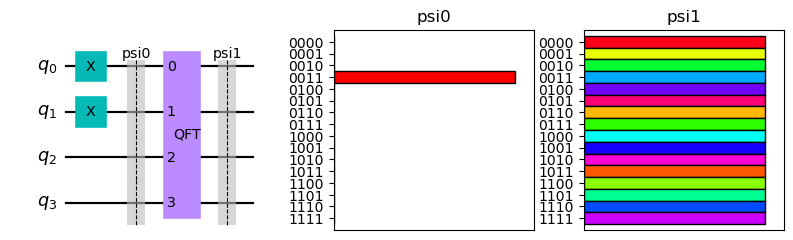

In [4]:
inputValues = 0b0011             # Try changing this!
n = 4
cir = qiskit.QuantumCircuit(n)
initStates (cir, inputValues)
cir.save_statevector ('psi0')
cir.append(qiskit.circuit.library.QFT(n), range(n))    # n-qubit quantum Fourier transform
cir.save_statevector ('psi1')
res = qute.run (cir)
psit = qute.getStatevectors (res, 'psi')
fig,axs = qute.axgrid ([[3,2,2]],[[2,2,2]], padl=[[.5,.5,.5]])
cir.draw ('mpl', ax=axs[0,0])
for t in range(len(psit)):
  ax = axs[0,1+t]
  qute.plotStatevector (psit[t], ax=ax, horiz=True); ax.set_title(f'psi{t}')

The $n$-bit QFT performs the operation

$\beq
\ket{j} \longrightarrow \frac{1}{\sqrt{N}}\sum_{k=0}^{N} e^{2\pi i j k/N} \ket{k}
\eeq$

In the above example, the initial state was $\ket{0011}=\ket{3}$.  The final state has equal amplitudes and the phase goes through 3 complete cycles.
where $N=2^n$.  Try changing the value of *inputValues* above and see if you can interpret the results!  

### QFT of a superposition state

If the input to the QFT is a superposition of two or more basis states, the output may be like a cosine wave, sine wave, or something else.  Try the example below.

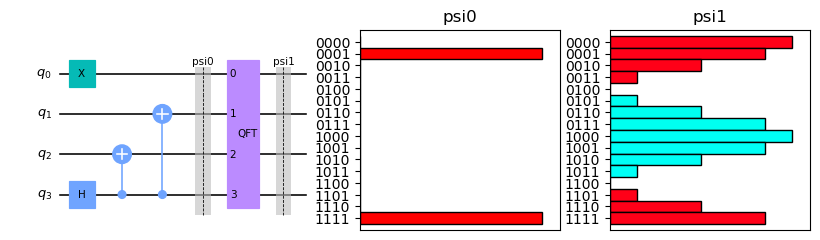

In [5]:
inputValues = [1,15]             # Try changing this to [2,14], [3,13], or [4,12]
n = 4
cir = qiskit.QuantumCircuit(n)
initStates (cir, inputValues)
cir.save_statevector ('psi0')
cir.append(qiskit.circuit.library.QFT(n), range(n))
cir.save_statevector ('psi1')
res = qute.run (cir)
psit = qute.getStatevectors (res, 'psi')
fig,axs = qute.axgrid ([[3,2,2]],[[2,2,2]], padl=[[.5,.5,.5]])
cir.draw ('mpl', ax=axs[0,0])
for t in range(len(psit)):
  ax = axs[0,1+t]
  qute.plotStatevector (psit[t], ax=ax, horiz=True); ax.set_title(f'psi{t}')

### Roll-your-own QFT

Finally, let's make our own implementation of the QFT.  For technical details, see course notes on Walsh and Fourier transforms.  A $n$-bit QFT can be implemented using approximately $n/2$ SWAP gates, $n$ Hadamard gates, and $n(n-1)/2$ CP gates.  This is not the most efficient implementation of the QFT, but it is good enough as an illustration:

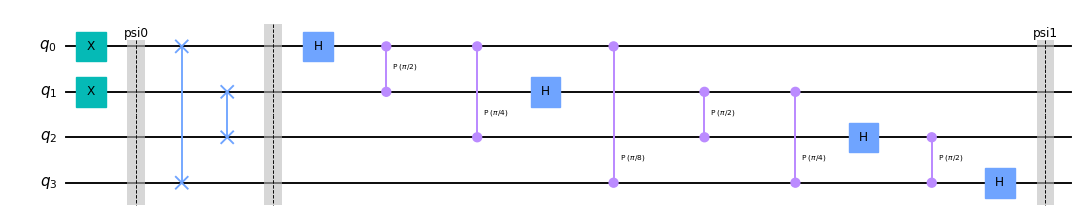

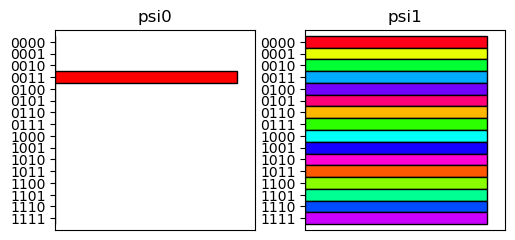

In [7]:
inputValues = 0b0011             # Try changing this!
n = 4
cir = qiskit.QuantumCircuit(n)
initStates (cir, inputValues)
cir.save_statevector ('psi0')
#======== QFT begins here
#-------- Do bit-reversal permutation using SWAP gates
cir.swap(0,3); cir.swap(1,2)
cir.barrier()
#-------- Butterflies using H gates and twiddles using CP gates
cir.h(0); cir.cp(np.pi/2, 1,0); cir.cp(np.pi/4, 2,0); cir.cp(np.pi/8, 3,0)
cir.h(1); cir.cp(np.pi/2, 2,1); cir.cp(np.pi/4, 3,1)
cir.h(2); cir.cp(np.pi/2, 3,2)
cir.h(3)
#======== QFT ends here
cir.save_statevector ('psi1')
res = qute.run (cir)
psit = qute.getStatevectors (res, 'psi')
fig,axs = qute.axgrid (11, 2)
cir.draw ('mpl', ax=axs[0,0])
fig,axs = qute.axgrid (2*[2], 2, padl=.5)
for t in range(len(psit)):
  ax = axs[0,t]
  qute.plotStatevector (psit[t], ax=ax, horiz=True); ax.set_title(f'psi{t}')

## 6. Shor's algorithm

Shor's algorithm is an efficient quantum algorithm for integer factorization.  The circuit below illustrates part of Shor's algorithm in a simple situation (factorizing the number 15):

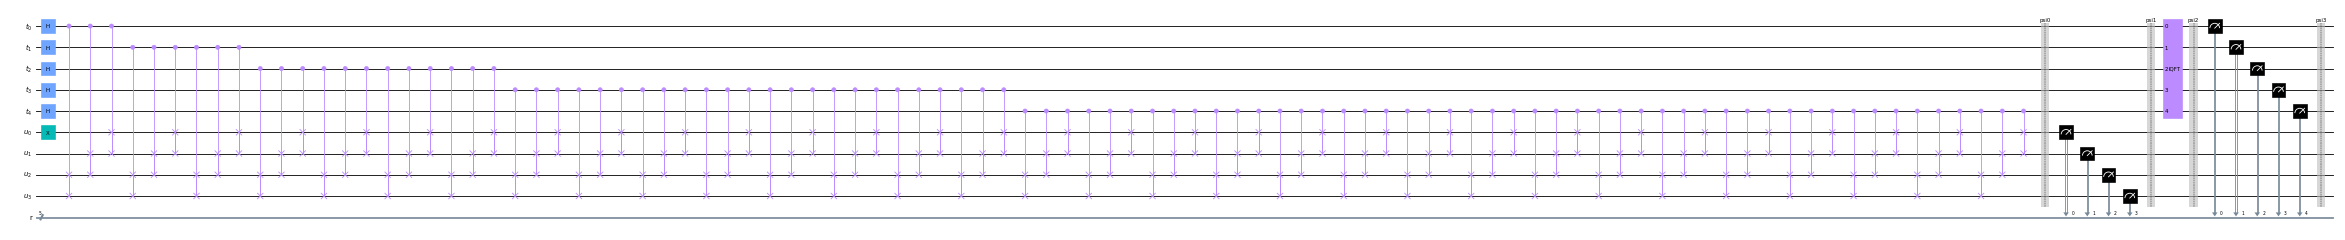

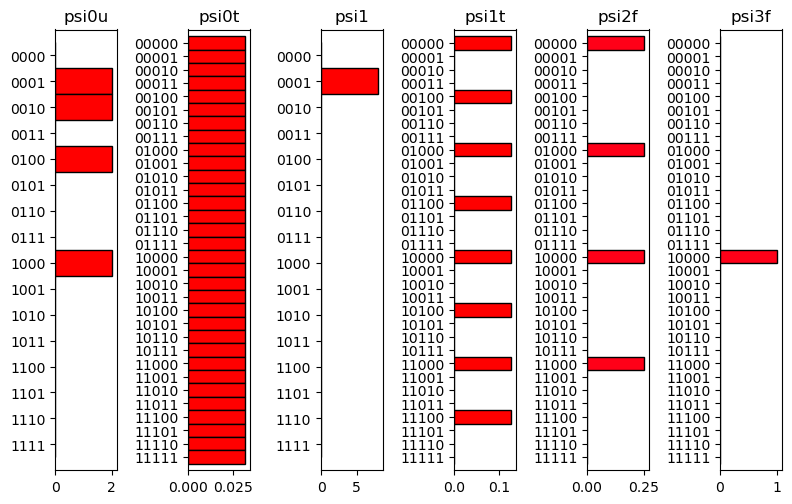

In [18]:
N = 5
M = 4
t = qiskit.QuantumRegister (N, name='t')
u = qiskit.QuantumRegister (M, name='u')
r = qiskit.ClassicalRegister (N, name='r') # results
cir = qiskit.QuantumCircuit (t, u, r)
cir.h (t)
cir.x (u[0])
for n in range(N):
  for iter in range(2**n):
    cir.cswap (t[n], u[3], u[2])
    cir.cswap (t[n], u[2], u[1])
    cir.cswap (t[n], u[1], u[0])
cir.save_statevector ('psi0')
cir.measure (u, r[:M])
cir.save_statevector ('psi1')
cir.append (qiskit.circuit.library.QFT(N).inverse(), t)
cir.save_statevector ('psi2')
cir.measure (t, r[:N])
cir.save_statevector ('psi3')
fig,ax = plt.subplots(figsize=(30,6))
cir.draw('mpl',justify='left',fold=-1,ax=ax)

#======== Run simulation and plot histogram of results
res = qute.run (cir)
psi = qute.getStatevectors (res, 'psi') 
psi0u = np.sum( psi[0].reshape ([2**M,2**N]) , axis=1)
psi0t = np.sum( psi[0].reshape ([2**M,2**N]) , axis=0)
psi1u = np.sum( psi[1].reshape ([2**M,2**N]) , axis=1)
psi1t = np.sum( psi[1].reshape ([2**M,2**N]) , axis=0)
psi2f = np.sum( psi[2].reshape ([2**M,2**N]) , axis=0)
psi3f = np.sum( psi[3].reshape ([2**M,2**N]) , axis=0) # ignore u
psi = [psi0u, psi0t, psi1u, psi1t, psi2f, psi3f]  # heterogeneous list
m = len(psi)
fig,axs = plt.subplots (1,m, figsize=(8,5)); fig.tight_layout(w_pad=2) 
# for i in range(m):
i=0; qute.plotStatevector (psi[i], ax=axs[i], horiz=True, tickInterval=1); axs[i].set_title (f'psi0u')
i=1; qute.plotStatevector (psi[i], ax=axs[i], horiz=True, tickInterval=1); axs[i].set_title (f'psi0t')
i=2; qute.plotStatevector (psi[i], ax=axs[i], horiz=True, tickInterval=1); axs[i].set_title (f'psi1')
i=3; qute.plotStatevector (psi[i], ax=axs[i], horiz=True, tickInterval=1); axs[i].set_title (f'psi1t')
i=4; qute.plotStatevector (psi[i], ax=axs[i], horiz=True, tickInterval=1); axs[i].set_title (f'psi2f');
i=5; qute.plotStatevector (psi[i], ax=axs[i], horiz=True, tickInterval=1); axs[i].set_title (f'psi3f');

The above circuit shows roughly how Shor's algorithm works, in the case where the base is $b=2$, the modulus is $m=15$, and the exponent $t$ is a 5-bit integer.
1. **Use Hadamard gates** to put the control/time/frequency register into a uniform superposition $\sum_{t=0}^{2^N-1} \ket{t}$.
2. **Compute $u = 2^t \mathrm{~mod~} 15$.  This produces an entangled state $\sum_{t=0}^{2^N-1} \ket{t} \otimes \ket{2^t \mathrm{~mod~} 15}$.**  At this point the statevector is $\psi_0$.  The first two columns show $\psi_0$ projected onto $u$ and $t$ registers respectively (psi0u and psi0t).  We see that $u$ is in a superposition of 4 possibilities (1, 2, 4, 8), and $t$ is in a superposition of $2^N$ possibilities.

3. **Measure $u$.**  Now the statevector is $\psi_1$.  This is visualized as psi1u and psi1t.  Te measurement has picked out a SINGLE value of $u$ (1, 2, 4, or 8).  The values of $t$ are now restricted.  The statevector has the form of a *shifted comb*.

4. **Do an inverse QFT on the $t$ register.**  Now the statevector is $\psi_2$.  See psi2f.  The IQFT has transformed the *shifted comb* in the $t$ domain to an *unshifted comb* in the $f$ domain.

5. **Measure the control register $t$.**  At this point the control register really represents frequency, rather than time.  See psi3f.  The measurement has picked out one of the teeth of the unshifted comb.  We will call this $f$.  

From this point onward the algorithm is classical.  Take the integer frequency $f$ and convert it to a physical frequency by dividing by $2^N$.  In the case of the function $u = 2^t \mathrm{~mod~} 15$, we will find one of four results for the physical frequency: $0, 1/4, 1/2$, or $3/4$.  This allows us to deduce that the fundamental frequency is $f_1 = 1/4$, and that the period of the function is $T = 4$.

If the period $T$ is even, compute $p = \text{GCD} (a^{T/2} + 1, m)$.  This is likely to be a factor of $m$.  For example:

$\quad$$a=2 \implies u=1,2,4,8,1,2,\dots \implies T=4 \implies  p = \text{GCD} (2^{4/2} + 1, 15) = 5$

$\quad$$a=3 \implies u=1,3,9,12,6,3,\dots \implies T=4 \implies  p = \text{GCD} (2^{4/2} + 1, 15) = 5$

$\quad$$a=4 \implies u=1,4,1,4,1,4,\dots \implies T=2 \implies  p = \text{GCD} (2^{2/2} + 1, 15) = 3$

$\quad$$a=5 \implies u=1,5,10,5,10,\dots \implies T=2 \implies  p = \text{GCD} (2^{2/2} + 1, 15) = 3$

$\quad$$a=6 \implies u=1,6,6,6,6,6,\dots \implies T=1$ (odd, so not useful)

This suggests that 3 and 5 are factors of 15.

The above implementation of Shor's algorithm calculates $u = b^t \mathrm{~mod~} m$ using **exponentiation by repeated multiplication**, where $t=0,\dots,2^N-1$.  With this simple method, the number of gates is $O(2^N)$.  (You can see that the circuit uses a large number of gates.)  This does NOT give a speedup over classical algorithms.

In order to get a quantum speedup, one needs to calculate $u = b^t \mathrm{~mod~} m$ using **exponentiation by squaring**.  This requires extra ancillary registers, but it reduces the number of gates to $O(N)$.  That implementation of Shor's algorithm would give exponential quantum speedup over classical algorithms.


## Exercises

1. Implement Grover's algorithm for 5 input bits.
2. Implement the QFT for 3 bits using SWAP, H, and CP gates.
3. Apply the QFT twice.  What gate or operation is this equivalent to?